## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

### Reference
* https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
* https://stats.stackexchange.com/questions/282544/why-does-reducing-the-learning-rate-quickly-reduce-the-error
* https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L906

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

## 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

In [8]:
# 載入 Callbacks
fact = [0.25,0.5,1]
pati = [1,5,10]

In [9]:
from keras.callbacks import ReduceLROnPlateau
results = {}
results = {}
"""
Set your training loop
"""
for fac, pat in itertools.product(fact, pati):
    reduce_lr = ReduceLROnPlateau(factor=fac,
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=pat,
                                  verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "factor-%s-patience-%s" % (str(fac), str(pat))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 41/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.0357 - acc: 0.6518 - val_loss: 1.4348 - val_acc: 0.4987
Epoch 42/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.0361 - acc: 0.6522 - val_loss: 1.4348 - val_acc: 0.4984
Epoch 43/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.0357 - acc: 0.6520 - val_loss: 1.4348 - val_acc: 0.4983
Epoch 44/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.0359 - acc: 0.6523 - val_loss: 1.4348 - val_acc: 0.4983
Epoch 45/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.0369 - acc: 0.6515 - val_loss: 1.4348 - val_acc: 0.4985
Epoch 46/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.0362 - acc: 0.6522 - val_loss: 1.4348 - val_acc: 0.4981
Epoch 47/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.0365 - acc: 0.6518 - val_loss: 1.4348 - val_acc: 0.4982
Epoch 48/50
50000/50000 [==

50000/50000 [==============================] - 7s 135us/step - loss: 0.8580 - acc: 0.7191 - val_loss: 1.4677 - val_acc: 0.4983
Epoch 39/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.8572 - acc: 0.7197 - val_loss: 1.4681 - val_acc: 0.4996
Epoch 40/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.8567 - acc: 0.7215 - val_loss: 1.4680 - val_acc: 0.5000
Epoch 41/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.8557 - acc: 0.7216 - val_loss: 1.4684 - val_acc: 0.4998
Epoch 42/50
50000/50000 [==============================] - 7s 132us/step - loss: 0.8559 - acc: 0.7211 - val_loss: 1.4680 - val_acc: 0.5001

Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 43/50
50000/50000 [==============================] - 7s 132us/step - loss: 0.8549 - acc: 0.7221 - val_loss: 1.4683 - val_acc: 0.5000
Epoch 44/50
50000/50000 [==============================] - 7s 132us/step - loss: 0.8546 - acc: 0.

Epoch 35/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.7847 - acc: 0.7473 - val_loss: 1.4812 - val_acc: 0.5041
Epoch 36/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.7791 - acc: 0.7504 - val_loss: 1.4863 - val_acc: 0.4975
Epoch 37/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.7735 - acc: 0.7521 - val_loss: 1.4882 - val_acc: 0.5016
Epoch 38/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.7679 - acc: 0.7557 - val_loss: 1.4874 - val_acc: 0.5053
Epoch 39/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.7624 - acc: 0.7579 - val_loss: 1.4947 - val_acc: 0.5000
Epoch 40/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.7574 - acc: 0.7580 - val_loss: 1.5012 - val_acc: 0.4969
Epoch 41/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.7513 - acc: 0.7602 - val_loss: 1.4921 - val_acc: 0.5026

Epoch 00041: ReduceLROnPla


Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 28/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.1733 - acc: 0.5997 - val_loss: 1.4539 - val_acc: 0.4926

Epoch 00028: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 29/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.1734 - acc: 0.5994 - val_loss: 1.4539 - val_acc: 0.4928

Epoch 00029: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 30/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.1737 - acc: 0.5988 - val_loss: 1.4539 - val_acc: 0.4927

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 31/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.1730 - acc: 0.5995 - val_loss: 1.4539 - val_acc: 0.4924

Epoch 00031: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 32/50
50000/50000 [============

50000/50000 [==============================] - 7s 132us/step - loss: 1.3357 - acc: 0.5336 - val_loss: 1.5076 - val_acc: 0.4629
Epoch 10/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.3049 - acc: 0.5470 - val_loss: 1.4981 - val_acc: 0.4728
Epoch 11/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.2771 - acc: 0.5564 - val_loss: 1.4972 - val_acc: 0.4696
Epoch 12/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.2497 - acc: 0.5649 - val_loss: 1.4932 - val_acc: 0.4714
Epoch 13/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.2256 - acc: 0.5748 - val_loss: 1.4755 - val_acc: 0.4787
Epoch 14/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.2003 - acc: 0.5853 - val_loss: 1.4627 - val_acc: 0.4806
Epoch 15/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.1772 - acc: 0.5940 - val_loss: 1.4609 - val_acc: 0.4797
Epoch 16/50
50000/50000 [==============

ValueError: ReduceLROnPlateau does not support a factor >= 1.0.

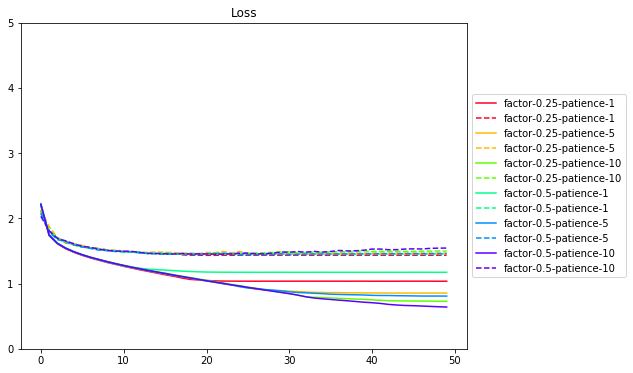

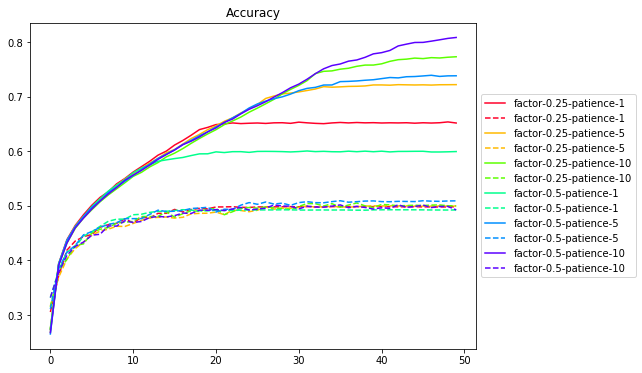

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

## Adam

In [12]:
from keras.callbacks import ReduceLROnPlateau
results = {}
"""
Set your training loop
"""
for fac, pat in itertools.product(fact, pati):
    reduce_lr = ReduceLROnPlateau(factor=fac,
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=pat,
                                  verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "factor-%s-patience-%s" % (str(fac), str(pat))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_24 (Batc (None, 128)               512       
__________

Epoch 41/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.0335 - acc: 0.6479 - val_loss: 1.3284 - val_acc: 0.5271
Epoch 42/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.0326 - acc: 0.6487 - val_loss: 1.3284 - val_acc: 0.5272
Epoch 43/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.0327 - acc: 0.6483 - val_loss: 1.3284 - val_acc: 0.5270
Epoch 44/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.0326 - acc: 0.6489 - val_loss: 1.3284 - val_acc: 0.5272
Epoch 45/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.0331 - acc: 0.6474 - val_loss: 1.3284 - val_acc: 0.5272
Epoch 46/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.0329 - acc: 0.6490 - val_loss: 1.3284 - val_acc: 0.5273
Epoch 47/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.0332 - acc: 0.6490 - val_loss: 1.3284 - val_acc: 0.5273
Epoch 48/50
50000/50000 [==

Epoch 33/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.3419 - acc: 0.9151 - val_loss: 1.5967 - val_acc: 0.5303
Epoch 34/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.3358 - acc: 0.9182 - val_loss: 1.6156 - val_acc: 0.5281
Epoch 35/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.3303 - acc: 0.9202 - val_loss: 1.6177 - val_acc: 0.5286

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 36/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.3158 - acc: 0.9266 - val_loss: 1.6075 - val_acc: 0.5342
Epoch 37/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.3131 - acc: 0.9282 - val_loss: 1.6126 - val_acc: 0.5352
Epoch 38/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.3110 - acc: 0.9293 - val_loss: 1.6157 - val_acc: 0.5343
Epoch 39/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.3


Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 24/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.8715 - acc: 0.7092 - val_loss: 1.3210 - val_acc: 0.5393

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 25/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.8714 - acc: 0.7107 - val_loss: 1.3212 - val_acc: 0.5393

Epoch 00025: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 26/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.8711 - acc: 0.7097 - val_loss: 1.3213 - val_acc: 0.5393

Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 27/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.8716 - acc: 0.7102 - val_loss: 1.3214 - val_acc: 0.5393

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
Epoch 28/50
50000/50000 [============

50000/50000 [==============================] - 7s 143us/step - loss: 1.2536 - acc: 0.5565 - val_loss: 2.2729 - val_acc: 0.2873
Epoch 6/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.1931 - acc: 0.5808 - val_loss: 2.1351 - val_acc: 0.3042
Epoch 7/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.1410 - acc: 0.5988 - val_loss: 2.1146 - val_acc: 0.3592
Epoch 8/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.0974 - acc: 0.6140 - val_loss: 2.2703 - val_acc: 0.3366
Epoch 9/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.0601 - acc: 0.6258 - val_loss: 1.7193 - val_acc: 0.4034
Epoch 10/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.0215 - acc: 0.6401 - val_loss: 1.9662 - val_acc: 0.3705
Epoch 11/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.9757 - acc: 0.6582 - val_loss: 1.8185 - val_acc: 0.4126
Epoch 12/50
50000/50000 [==================

ValueError: ReduceLROnPlateau does not support a factor >= 1.0.

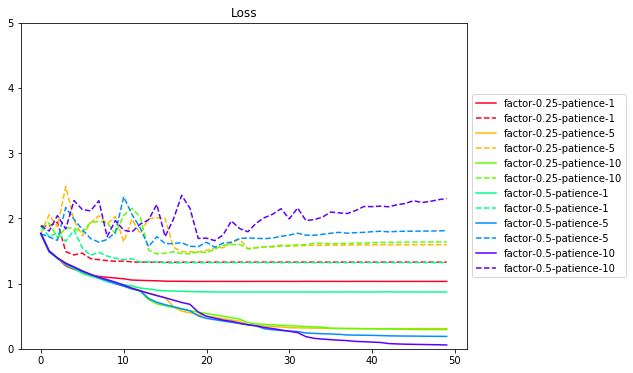

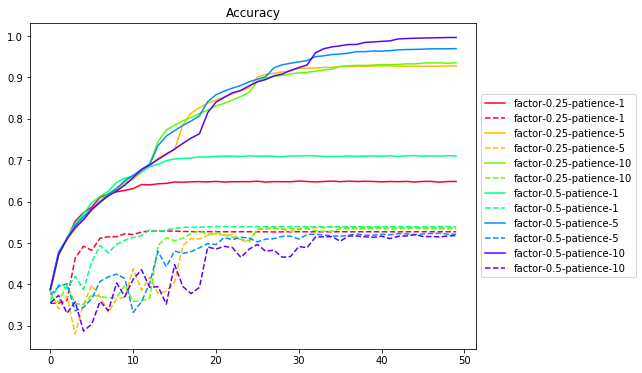

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## RMSprop

In [15]:
from keras.callbacks import ReduceLROnPlateau
results = {}
"""
Set your training loop
"""
for fac, pat in itertools.product(fact, pati):
    reduce_lr = ReduceLROnPlateau(factor=fac,
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=pat,
                                  verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.RMSprop(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "factor-%s-patience-%s" % (str(fac), str(pat))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_44 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_45 (Batc (None, 128)               512       
__________

Epoch 41/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.0069 - acc: 0.6570 - val_loss: 1.3128 - val_acc: 0.5367
Epoch 42/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.0067 - acc: 0.6570 - val_loss: 1.3128 - val_acc: 0.5370
Epoch 43/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.0071 - acc: 0.6572 - val_loss: 1.3128 - val_acc: 0.5364
Epoch 44/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.0070 - acc: 0.6568 - val_loss: 1.3128 - val_acc: 0.5364
Epoch 45/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.0075 - acc: 0.6565 - val_loss: 1.3128 - val_acc: 0.5364
Epoch 46/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.0072 - acc: 0.6569 - val_loss: 1.3128 - val_acc: 0.5364
Epoch 47/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.0072 - acc: 0.6578 - val_loss: 1.3128 - val_acc: 0.5367
Epoch 48/50
50000/50000 [==

Epoch 34/50
50000/50000 [==============================] - 7s 144us/step - loss: 0.3287 - acc: 0.9070 - val_loss: 1.7244 - val_acc: 0.5172
Epoch 35/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.3164 - acc: 0.9115 - val_loss: 1.7587 - val_acc: 0.5087
Epoch 36/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.3033 - acc: 0.9180 - val_loss: 1.7722 - val_acc: 0.5153
Epoch 37/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2935 - acc: 0.9208 - val_loss: 1.8095 - val_acc: 0.5141
Epoch 38/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2809 - acc: 0.9255 - val_loss: 1.8978 - val_acc: 0.5009

Epoch 00038: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 39/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.2404 - acc: 0.9443 - val_loss: 1.7711 - val_acc: 0.5285
Epoch 40/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.234

50000/50000 [==============================] - 7s 141us/step - loss: 1.0198 - acc: 0.6413 - val_loss: 1.7703 - val_acc: 0.4072
Epoch 13/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.9817 - acc: 0.6557 - val_loss: 2.3019 - val_acc: 0.3357
Epoch 14/50
50000/50000 [==============================] - 7s 145us/step - loss: 0.9603 - acc: 0.6608 - val_loss: 1.6970 - val_acc: 0.4314
Epoch 15/50
50000/50000 [==============================] - 8s 167us/step - loss: 0.9265 - acc: 0.6766 - val_loss: 2.0465 - val_acc: 0.3836
Epoch 16/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.8997 - acc: 0.6861 - val_loss: 2.2669 - val_acc: 0.3502
Epoch 17/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.8708 - acc: 0.6934 - val_loss: 2.2641 - val_acc: 0.3585
Epoch 18/50
50000/50000 [==============================] - 7s 144us/step - loss: 0.8348 - acc: 0.7077 - val_loss: 1.7623 - val_acc: 0.4292
Epoch 19/50
50000/50000 [==============

ValueError: ReduceLROnPlateau does not support a factor >= 1.0.

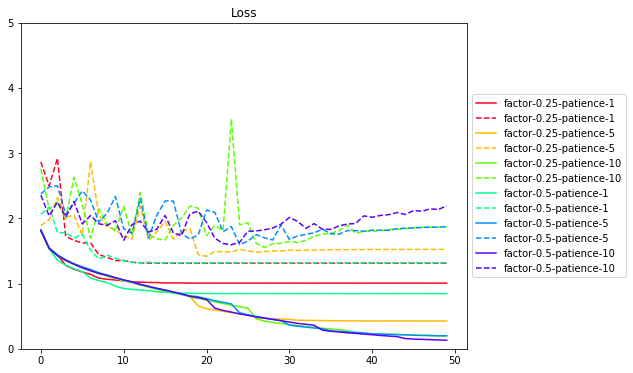

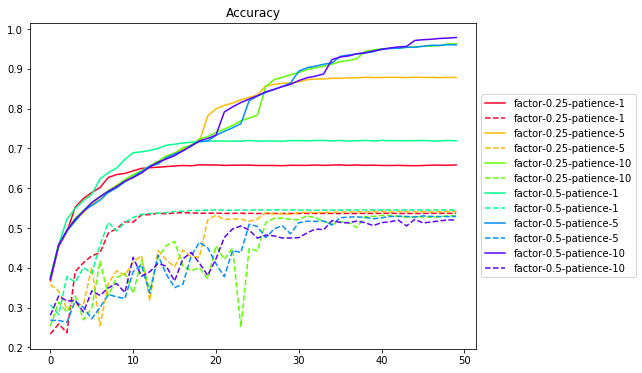

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
